### MEME CLASSIFICATION PROJECT Project - Part 2 - Multi Label Neural Network

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from skimage.io import imread, imshow
from PIL import Image, ImageOps, ImageFile, ImageFilter
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
import nltk
nltk.download('punkt')
from nltk import word_tokenize
import torch 
import torch.nn as nn

[nltk_data] Downloading package punkt to /home/usman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Directing Paths to Folders

In [45]:
path = '/home/usman/Desktop/AI - Project - 2022/archive_part2/memotion_dataset_7k/images'
glove_file = '/home/usman/Desktop/AI - Project - 2022/glove.6B/glove.6B.100d.txt'
label_xlsx_path = "/home/usman/Desktop/AI - Project - 2022/archive_part2/memotion_dataset_7k/labels.xlsx"
path_images_info = "/home/usman/Desktop/AI - Project - 2022/images_info.csv"
model_path = "/home/usman/Desktop/AI - Project - 2022/part2_model.pt"
labels_path_part2 = '/home/usman/Desktop/AI - Project - 2022/part2.csv'

# input path 
# original_img_path = "/home/usman/Desktop/AI - Project - 2022/archive_part2/memotion_dataset_7k/images/"
# os.chdir(original_img_path)
# images = os.listdir(os.getcwd())
# print(len(images))

# path = '/home/gpu2/Desktop/Usman Naveed/Part 2/archive_part2/memotion_dataset_7k/images'
# glove_file = '/home/gpu2/Desktop/Usman Naveed/Part 2/glove.6B.100d.txt'
# label_xlsx_path = "/home/gpu2/Desktop/Usman Naveed/Part 2/labels.xlsx"
# path_images_info = "/home/gpu2/Desktop/Usman Naveed/Part 2/images_info.csv"
# model_path = "/home/gpu2/Desktop/Usman Naveed/Part 2/model_MMNN_part2.pt"
# labels_path_part2 = '/home/gpu2/Desktop/Usman Naveed/Part 2/part2.csv'

### Image - Preprocessing

In [5]:
os.chdir(path)
images = os.listdir(path)
print(len(images))

6989


#### Making a Dataframe of the Original Images

In [6]:
# Convert it to Dataframe
def convert_to_df(images):
    df = pd.DataFrame(columns=['image','size','width','height'])
    for image in images:
        img = Image.open(image)
        img_size = img.size
        df = df.append({'image':image, 'size':os.path.getsize(image), 'width':img_size[0], 'height':img_size[1]}, ignore_index=True)
    return df

# df = convert_to_df(images)
# df.to_csv(path_images_info, index=False)
df = pd.read_csv(path_images_info)
df 

,image,size,width,height
0,image_1467.jpg,122310,728,728
1,image_6363.jpg,40790,430,241
2,image_3356.png,150774,500,567
3,image_4500.jpg,40977,720,720
4,image_3819.jpg,21254,225,316
...,...,...,...,...
6987,image_1255.jpg,107475,1024,768
6988,image_773.jpg,63966,625,439
6989,image_5568.jpg,72639,960,960
6990,image_1053.jpg,114875,700,466


#### Getting Maximum Shapes of images

In [7]:
def get_largest_sizes():
    largest_image = df.loc[df['size'] == df['size'].max()]
    print("Largest Image: ", largest_image['image'].values[0])
    img = Image.open(largest_image.iloc[0]['image'])
    print(img.size)
    # imshow(imread(largest_image.iloc[0]['image']))

    smallest_image = df.loc[df['size'] == df['size'].min()]
    print("Smallest Image: ", smallest_image['image'].values[0])
    img = Image.open(smallest_image.iloc[0]['image'])
    print(img.size)
    # imshow(imread(smallest_image.iloc[0]['image']))

# get_largest_sizes()

#### Scatter Plot for the Shapes - Width * Height

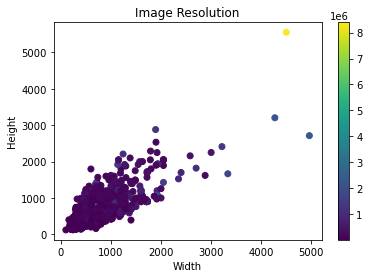

In [8]:
# Visualize Image Resolutions with Scatter plot
def scatter_plot_sizes():
    plt.scatter(df['width'], df['height'], c=df['size'], cmap='viridis')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Image Resolution')
    plt.colorbar()
    plt.show()
    
scatter_plot_sizes()

#### Selecting Images of Shape Under 2500 * 2500

In [9]:
# Selecting images with height and width less than 2500
selected_images = df[(df['width'] < 2500) & (df['height'] < 2500)]
selected_images

,image,size,width,height
0,image_1467.jpg,122310,728,728
1,image_6363.jpg,40790,430,241
2,image_3356.png,150774,500,567
3,image_4500.jpg,40977,720,720
4,image_3819.jpg,21254,225,316
...,...,...,...,...
6987,image_1255.jpg,107475,1024,768
6988,image_773.jpg,63966,625,439
6989,image_5568.jpg,72639,960,960
6990,image_1053.jpg,114875,700,466


#### Average Size for Resizing

In [10]:
# Select the Average Image Resolution
def get_avg_resolution(df):
    avg_width = df['width'].mean()
    avg_height = df['height'].mean()
    max_shape = (avg_width, avg_height)
    # round the shape to the nearest 100
    max_shape = (round(max_shape[0]), round(max_shape[1]))
    print("Average Image Resolution: ", max_shape)
    return max_shape
max_shape = get_avg_resolution(selected_images)
max_shape = (150,150)
print("Selected Image Resolution: ", max_shape)

Average Image Resolution:  (583, 543)
Selected Image Resolution:  (150, 150)


#### Resizing

In [11]:
# Resize the image to the max resolution
def resize_images(images):
    for image in images:
        img = Image.open(image)
        # check if mode is not RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize(max_shape, Image.ANTIALIAS)
        img.save(image)

# resize_images(selected_images['image'].to_list())

#### Extrating Features by Canny Edge Detection Algorithm

In [12]:
# Extracting the Image Features using Cannied Edge Detection Algorithm
from skimage.feature import canny

def extract_canny_features(images):
    for image in images:
        img = Image.open(image)
        img = img.convert('L') # Convert to Grayscale
        img = np.array(img)
        edges = canny(img, sigma=3, low_threshold=10, high_threshold=50)
        # edges = edges.astype(np.uint8) * 255 
        save_img = Image.fromarray(edges)
        save_img.save(image)

# extract_canny_features(selected_images['image'].to_list())

#### Making all images to .jpg

In [13]:
# convert all to .jpg
def convert_to_jpg(images):
    for image in images:
        img = Image.open(image)
        image.replace('.png','.jpg')
        image.replace('.jpeg','.jpg')
        image.replace('.JPG','.jpg')
        image.replace('.JPEG','.jpg')
        image.replace('.PNG','.jpg')
        img.save(image)

convert_to_jpg(selected_images['image'].to_list())

#### Selecting the Label Column

In [14]:
# Label Column 
label_path = label_xlsx_path
df_label = pd.read_excel(label_path)
df_label.head()
df_label.drop(columns=['Unnamed: 0'], inplace=True)

# select overall_sentiment column and replace 'positive' and 'negative' with int(1) and int(0)
df_label['overall_sentiment'] = df_label['overall_sentiment'].replace(['positive', 'negative'], [1, 0])
df_label['overall_sentiment'] = df_label['overall_sentiment'].replace(['very_positive', 'very_negative'], [1, 0])
df_label['overall_sentiment'] = df_label['overall_sentiment'].replace(['neutral'], [2])
df_label['overall_sentiment'] = df_label['overall_sentiment'].astype(int)

# Humour Column
df_label['humour'] = df_label['humour'].replace(['funny', 'very_funny', 'hilarious'], [1, 1, 1])
df_label['humour'] = df_label['humour'].replace(['not_funny'], [0])
df_label['humour'] = df_label['humour'].astype(int)

# Sarcasm Column
df_label['sarcasm'] = df_label['sarcasm'].replace(['general', 'very_twisted', 'twisted_meaning'], [1, 1, 1])
df_label['sarcasm'] = df_label['sarcasm'].replace(['not_sarcastic'], [0])
df_label['sarcasm'] = df_label['sarcasm'].astype(int)

# Offensive Column
df_label['offensive'] = df_label['offensive'].replace(['very_offensive', 'slight', 'hateful_offensive'], [1, 1, 1])
df_label['offensive'] = df_label['offensive'].replace(['not_offensive'], [0])
df_label['offensive'] = df_label['offensive'].astype(int)

# Motivational Column
df_label['motivational'] = df_label['motivational'].replace(['not_motivational', 'motivational'] , [0, 1])
df_label['motivational'] = df_label['motivational'].astype(int)

#### Deleting Rows of the Oversized Images and Replacing NaNof text_corrected to text

In [15]:
# delete images from folder that are not in selected_images
for image in images:
    if image not in selected_images['image'].to_list():
        os.remove(image)
images = os.listdir(path)

os.chdir(path)
images = os.listdir(os.getcwd())
print("Images in Folder: ", len(images))

df_label = df_label[df_label['image_name'].isin(selected_images['image'].to_list())]
print("Length of DF: ", len(df_label))

Images in Folder:  6981
Length of DF:  6981


In [16]:
df_label

,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,1,1,0,0,1
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,0,1,0,1,1
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,1,0,0,0,1
3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,1,1,1,1,1
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,1,1,1,0,2
...,...,...,...,...,...,...,...,...
6987,image_6988.jpg,Tuesday is Mardi Gras Wednesday is Valentine's...,Tuesday is Mardi Gras Wednesday is Valentine's...,1,1,1,1,2
6988,image_6989.jpg,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,1,1,0,0,2
6989,image_6990.png,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,1,1,1,0,1
6990,image_6991.jpg,When I VERY have time is a fantasy No one has ...,When I have time is a fantasy. no one has time...,0,1,0,1,1


In [17]:
# delete images from folder that are not in selected_images
for image in images:
    if image not in selected_images['image'].to_list():
        try:
            os.remove(image)
        except:
            print("File not found")

os.chdir(path)
images = os.listdir(os.getcwd())
print("Images in Folder: ", len(images))

df_label = df_label[df_label['image_name'].isin(selected_images['image'].to_list())]
print("Length of DF: ", len(df_label))

Images in Folder:  6981
Length of DF:  6981


In [18]:
# Create a new dataframe with the images in the images folder
def create_df_images(df_label):
    new_df = pd.DataFrame(columns=['image_name', 'text_ocr', 'text_corrected', 'humour', 'sarcasm', 'offensive', 'motivational', 'overall_sentiment'])
    for i in images:
        new_df = new_df.append({'image_name': i, 'text_ocr': df_label.loc[df_label['image_name'] == i, 'text_ocr'].values[0], 'text_corrected': df_label.loc[df_label['image_name'] == i, 'text_corrected'].values[0], 'humour': df_label.loc[df_label['image_name'] == i, 'humour'].values[0], 'sarcasm': df_label.loc[df_label['image_name'] == i, 'sarcasm'].values[0], 'offensive': df_label.loc[df_label['image_name'] == i, 'offensive'].values[0], 'motivational': df_label.loc[df_label['image_name'] == i, 'motivational'].values[0], 'overall_sentiment': df_label.loc[df_label['image_name'] == i, 'overall_sentiment'].values[0]}, ignore_index=True)

    return new_df

# new_df = create_df_images(df_label)

# df_label = new_df
# df_label.head()

In [19]:
# df_label.to_csv(labels_path_part2)
df_label = pd.read_csv(labels_path_part2)

#### Function that return the original name of the augmented images

In [20]:
def if_augmented_img_replace_name(img):
    if "flip" or "topdown" or "rotate_ninty" or "rotate_oneighty" or "flip_diagonal" or "flip_diagonal_oneighty" or "flip_diagonal_twoseventy" in img:
        img  = img.replace('_flip.jpg', '.jpg')
        img  = img.replace('_topdown.jpg', '.jpg')
        img  = img.replace('_rotate_ninty.jpg', '.jpg')
        img  = img.replace('_rotate_oneighty.jpg', '.jpg')
        img  = img.replace('_flip_diagonal.jpg', '.jpg')
        img  = img.replace('_flip_diagonal_oneighty.jpg', '.jpg')
        img  = img.replace('_flip_diagonal_twoseventy.jpg', '.jpg')
        img = img.replace('_flip_diagonal_twoseventy_oneighty.jpg', '.jpg')
        img = img.replace('_flip_diagonal_twoseventy_twoseventy.jpg', '.jpg')
        img = img.replace('_flip_diagonal_twoseventy_twoseventy_oneighty.jpg', '.jpg')
    return img

#### Get Image Features

In [21]:
# Get Image Features

def get_image_features(image_name):
    img = Image.open(image_name)
    img = np.array(img)
    img = img.flatten()
    # label = df_label[df_label['image_name'] == image_name]['overall_sentiment'].values[0]
    img = torch.from_numpy(img).float()
    # label = torch.from_numpy(np.array(label)).long()
    return img

x = get_image_features('image_8.jpg')
print(x)

tensor([ 0.,  0.,  0.,  ..., 11., 22.,  0.])


#### Get Label as Tensor

In [22]:
# Get Label Features

def get_label_features(image_name):

    output_label_cols = ['humour', 'sarcasm', 'offensive', 'motivational']
    labels = df_label[df_label['image_name'] == image_name][output_label_cols].values.tolist()
    labels = torch.tensor(labels)
    labels = labels.float()
    return labels

print(get_label_features('image_8.jpg'))

tensor([[1., 1., 0., 0.]])


### Text - Preprocessing

In [23]:
replace_NaN_with = ["CHALLENGE ACCEPTED! Friend: You can't honestly watch How I Met Your Mother again for like the 4th time.. Me:" ,"I'M GONNA BUILD SOME FANCY WALLS EVEN THOUGHIHAVE MILLIONS OF EXTRA DOLLARS IN GONNA MAKE THE MEXICANS PAY FORIT"
       ,"IF DONALD AND HILLARY ARE TOGETHER ON A BOAT IN THE MIDDLE OF THE OCEAN AND IT SINKS. WHO SURVIVES? AMERICA"
       ,"Bruh why this tub of margarine look like Donald Trump?"
       ,"2016 ELECTION TRUMPS HILIARY STILL'A BETTER LOVE STORY THAN TWILIGHT"]

df_label[df_label['text_corrected'].isna()]
df_label.loc[df_label['text_corrected'].isna(), 'text_corrected'] = replace_NaN_with

#### Loading Glove Model

In [24]:
# Loading Glove
def load_glove_model(glove_file):
    print("Loading Glove Model")
    f = open(glove_file, encoding="utf8")
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.", len(model), " words loaded!")
    return model

glove_model = load_glove_model(glove_file)

# Reference: https://www.kaggle.com/jamesmcguigan/word-embeddings-for-sentiment-analysis

Loading Glove Model
Done. 400000  words loaded!


In [25]:
x = glove_model['usman']
# print(x)
print(len(x))

100


#### Get Text Features and Padding them according to the highest Vector Length

In [26]:
# Get Text Features 
max_len_feature_vector = 20700

def get_text_features(image):
    text = str(df_label[df_label['image_name'] == image]['text_corrected'].values[0])
    text = text.lower()
    tokens = word_tokenize(text)
    features = np.zeros((1, 100))
    for word in tokens:
        try:
            vec = glove_model[word]
            features = np.vstack((features, vec)) # add the vector to the features, without vstack it will add the vector to the last row
        except KeyError:
            continue
    # Flatten 
    features = features[1:] # remove the first row
    features = features.flatten()
    # Padding
    features = np.pad(features, (0, max_len_feature_vector - len(features)), 'constant')
    # make it a tensor and float for training the model
    features = torch.from_numpy(features).float()
    
    return features

t = get_text_features('image_8.jpg')
print(t)
print(len(t))

tensor([0.0868, 0.3431, 0.0153,  ..., 0.0000, 0.0000, 0.0000])
20700


### Create Datasets for Training, Testing, Validation

In [27]:
# Create the 80 percent images as train and 20 percent images as test
def create_data(images ,df_label):
    training_dataset = []
    # Get the Proportion for 75% training images 
    train_size = int(len(df_label) * 0.75)
    label_0_count = label_1_count = label_2_count = int(train_size / 3)
    print ("Label Count Should be: ", label_0_count, label_1_count, label_2_count)
    for i in range(0, len(df_label)):
        if label_0_count == 0 or label_1_count == 0 or label_2_count == 0:
            break
        label = df_label.iloc[i]['overall_sentiment']
        if label == 0:
            training_dataset.append(df_label.iloc[i]['image_name'])
            label_0_count -= 1
        elif label == 1:
            training_dataset.append(df_label.iloc[i]['image_name'])
            label_1_count -= 1
        elif label == 2:
            training_dataset.append(df_label.iloc[i]['image_name'])
            label_2_count -= 1
    # print ("Label Count: ", label_0_count, label_1_count, label_2_count)
    return training_dataset

training_dataset = create_data(images, df_label)

# Count the number of positive, negative and neutral images in the training set
l0, l1, l3 = 0, 0, 0
for i in range(0, len(training_dataset)):
    if df_label.iloc[i]['overall_sentiment'] == 0:
        l0 += 1
    elif df_label.iloc[i]['overall_sentiment'] == 1:
        l1 += 1
    elif df_label.iloc[i]['overall_sentiment'] == 2:
        l3 += 1
# print ("Final Label Count in Training Dataset: ", l0, l1, l3)
print(len(training_dataset))

Label Count Should be:  1745 1745 1745
2923


In [28]:
def create_test_data(images ,df_label):
    test_dataset = []
    # Select Random 1000 images from the training dataset
    for i in range(0, len(df_label)):
        if len(test_dataset) == 1000:
            break
        # if the image is not in the training dataset
        if df_label.iloc[i]['image_name'] not in training_dataset:
            test_dataset.append(df_label.iloc[i]['image_name'])
    return test_dataset

test_images = create_test_data(images, df_label)
print(len(test_images))


1000


#### Dataloader 

In [29]:
# Create a Dataset Loader having image_name as input and output_label_cols as output 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class MultiLabelDataset(Dataset):
    def __init__(self, images, df_label, transform=None):
        self.images = images
        self.df_label = df_label
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        image_name = self.images[index]

        img_f = get_image_features(image_name)
    
        text_f = get_text_features(image_name)

        labels = get_label_features(image_name)

        # return img_f, text_f, labels
    
        sample = {'image': img_f, 'text': text_f, 'labels': labels}
#         sample = {'image': img_f.cuda(), 'text': text_f.cuda(), 'labels': labels.cuda()}
        

        return sample

# Create a data loader for the training dataset
train_dataset = MultiLabelDataset(training_dataset, df_label, transform=transforms.ToTensor())
# train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
print((train_dataset.__getitem__(0)))

{'image': tensor([ 3.,  0., 14.,  ...,  0.,  0.,  0.]), 'text': tensor([-0.0667,  0.1631,  0.3910,  ...,  0.0000,  0.0000,  0.0000]), 'labels': tensor([[1., 1., 0., 0.]])}


In [30]:
# Make the data loader for the test dataset
test_dataset = MultiLabelDataset(test_images, df_label, transform=transforms.ToTensor())


## Multi Label Classification - Neural Network 

#### Create Model and Architecture

In [51]:
class MultiLabelClassification_NN(nn.Module):
    def __init__(self,  
    Net1_input, Net1_hidden1, Net1_hidden2, Net1_hidden3,
    Net2_input, Net2_hidden1, Net2_hidden2, Net2_hidden3,
    concat_hidden1, concat_hidden2, concat_hidden3, output,
    humour_hidden1, humour_hidden2, humour_hidden3,
    sarcasm_hidden1, sarcasm_hidden2, sarcasm_hidden3,
    offensive_hidden1, offensive_hidden2, offensive_hidden3,
    motivational_hidden1, motivational_hidden2, motivational_hidden3):

        super(MultiLabelClassification_NN, self).__init__()

        self.Image_NN = nn.Sequential(
            nn.Linear(Net1_input, Net1_hidden1),
            nn.ReLU(),
            nn.Linear(Net1_hidden1, Net1_hidden2),
            nn.ReLU(),
            nn.Linear(Net1_hidden2, Net1_hidden3)
        )
        
        self.Text_NN = nn.Sequential(
            nn.Linear(Net2_input, Net2_hidden1),
            nn.Sigmoid(),
            nn.Linear(Net2_hidden1, Net2_hidden2),
            nn.Sigmoid(),
            nn.Linear(Net2_hidden2, Net2_hidden3)
        )

        # Concatenate the two NN and perform a linear layer and a hidden layer then concat_hidden layer
        self.concatenate_NN = nn.Sequential(
            nn.Linear(Net1_hidden3 + Net2_hidden3, concat_hidden1),
            nn.ReLU(),
            nn.Linear(concat_hidden1, concat_hidden2),
            nn.Sigmoid(),
            nn.Linear(concat_hidden2, concat_hidden3),
            nn.ReLU(),
            nn.Linear(concat_hidden3, output)
        )

        self.HumourLayers = nn.Sequential(
            nn.Linear(output, humour_hidden1),
            nn.ReLU(),
            nn.Linear(humour_hidden1, humour_hidden2),
            nn.Sigmoid(),
            nn.Linear(humour_hidden2, humour_hidden3),
            nn.Sigmoid()
        )

        self.SarcasmLayers = nn.Sequential(
            nn.Linear(output, sarcasm_hidden1),
            nn.ReLU(),
            nn.Linear(sarcasm_hidden1, sarcasm_hidden2),
            nn.Sigmoid(),
            nn.Linear(sarcasm_hidden2, sarcasm_hidden3),
            nn.Sigmoid()
        )

        self.OffensiveLayers = nn.Sequential(
            nn.Linear(output, offensive_hidden1),
            nn.ReLU(),
            nn.Linear(offensive_hidden1, offensive_hidden2),
            nn.Sigmoid(),
            nn.Linear(offensive_hidden2, offensive_hidden3),
            nn.Sigmoid()
        )

        self.MotivationalLayers = nn.Sequential(
            nn.Linear(output, motivational_hidden1),
            nn.ReLU(),
            nn.Linear(motivational_hidden1, motivational_hidden2),
            nn.Sigmoid(),
            nn.Linear(motivational_hidden2, motivational_hidden3),
            nn.Sigmoid()
        )

    def forward(self, img_f, text_f):
        img_f = self.Image_NN(img_f)
        text_f = self.Text_NN(text_f)

        # Concatenate the two NN
        concat_f = torch.cat([img_f, text_f], 1)
        concat_out = self.concatenate_NN(concat_f)

        humour_out = self.HumourLayers(concat_out)
        sarcasm_out = self.SarcasmLayers(concat_out)
        offensive_out = self.OffensiveLayers(concat_out)
        motivational_out = self.MotivationalLayers(concat_out)

        return (humour_out, sarcasm_out, offensive_out, motivational_out)


# Hyperparameters
Net1_input = 150*150 # 400 * 400 = 160000
Net1_hidden1 = 500
Net1_hidden2 = 220
Net1_hidden3 = 100
Net2_input = 20700 # 20700
Net2_hidden1 = 450
Net2_hidden2 = 250
Net2_hidden3 = 150
concat_hidden1 = 120
concat_hidden2 = 100
concat_hidden3 = 80
output = 50
humour_hidden1 = 40
humour_hidden2 = 20
humour_hidden3 = 2
sarcasm_hidden1 = 40
sarcasm_hidden2 = 20
sarcasm_hidden3 = 2
offensive_hidden1 = 40
offensive_hidden2 = 20
offensive_hidden3 = 2
motivational_hidden1 = 40
motivational_hidden2 = 20
motivational_hidden3 = 2

model = MultiLabelClassification_NN(
    Net1_input, Net1_hidden1, Net1_hidden2, Net1_hidden3,
    Net2_input, Net2_hidden1, Net2_hidden2, Net2_hidden3,
    concat_hidden1, concat_hidden2, concat_hidden3, output,
    humour_hidden1, humour_hidden2, humour_hidden3,
    sarcasm_hidden1, sarcasm_hidden2, sarcasm_hidden3,
    offensive_hidden1, offensive_hidden2, offensive_hidden3,
    motivational_hidden1, motivational_hidden2, motivational_hidden3)
print("Parameters: ", model.parameters)

Parameters:  <bound method Module.parameters of MultiLabelClassification_NN(
  (Image_NN): Sequential(
    (0): Linear(in_features=22500, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=220, bias=True)
    (3): ReLU()
    (4): Linear(in_features=220, out_features=100, bias=True)
  )
  (Text_NN): Sequential(
    (0): Linear(in_features=20700, out_features=450, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=450, out_features=250, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=250, out_features=150, bias=True)
  )
  (concatenate_NN): Sequential(
    (0): Linear(in_features=250, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=80, bias=True)
    (5): ReLU()
    (6): Linear(in_features=80, out_features=50, bias=True)
  )
  (HumourLayers): Sequential(
    (0): Linear(in_features=50, out_features=40, bias=Tr

#### Model Architecture - Visualization 

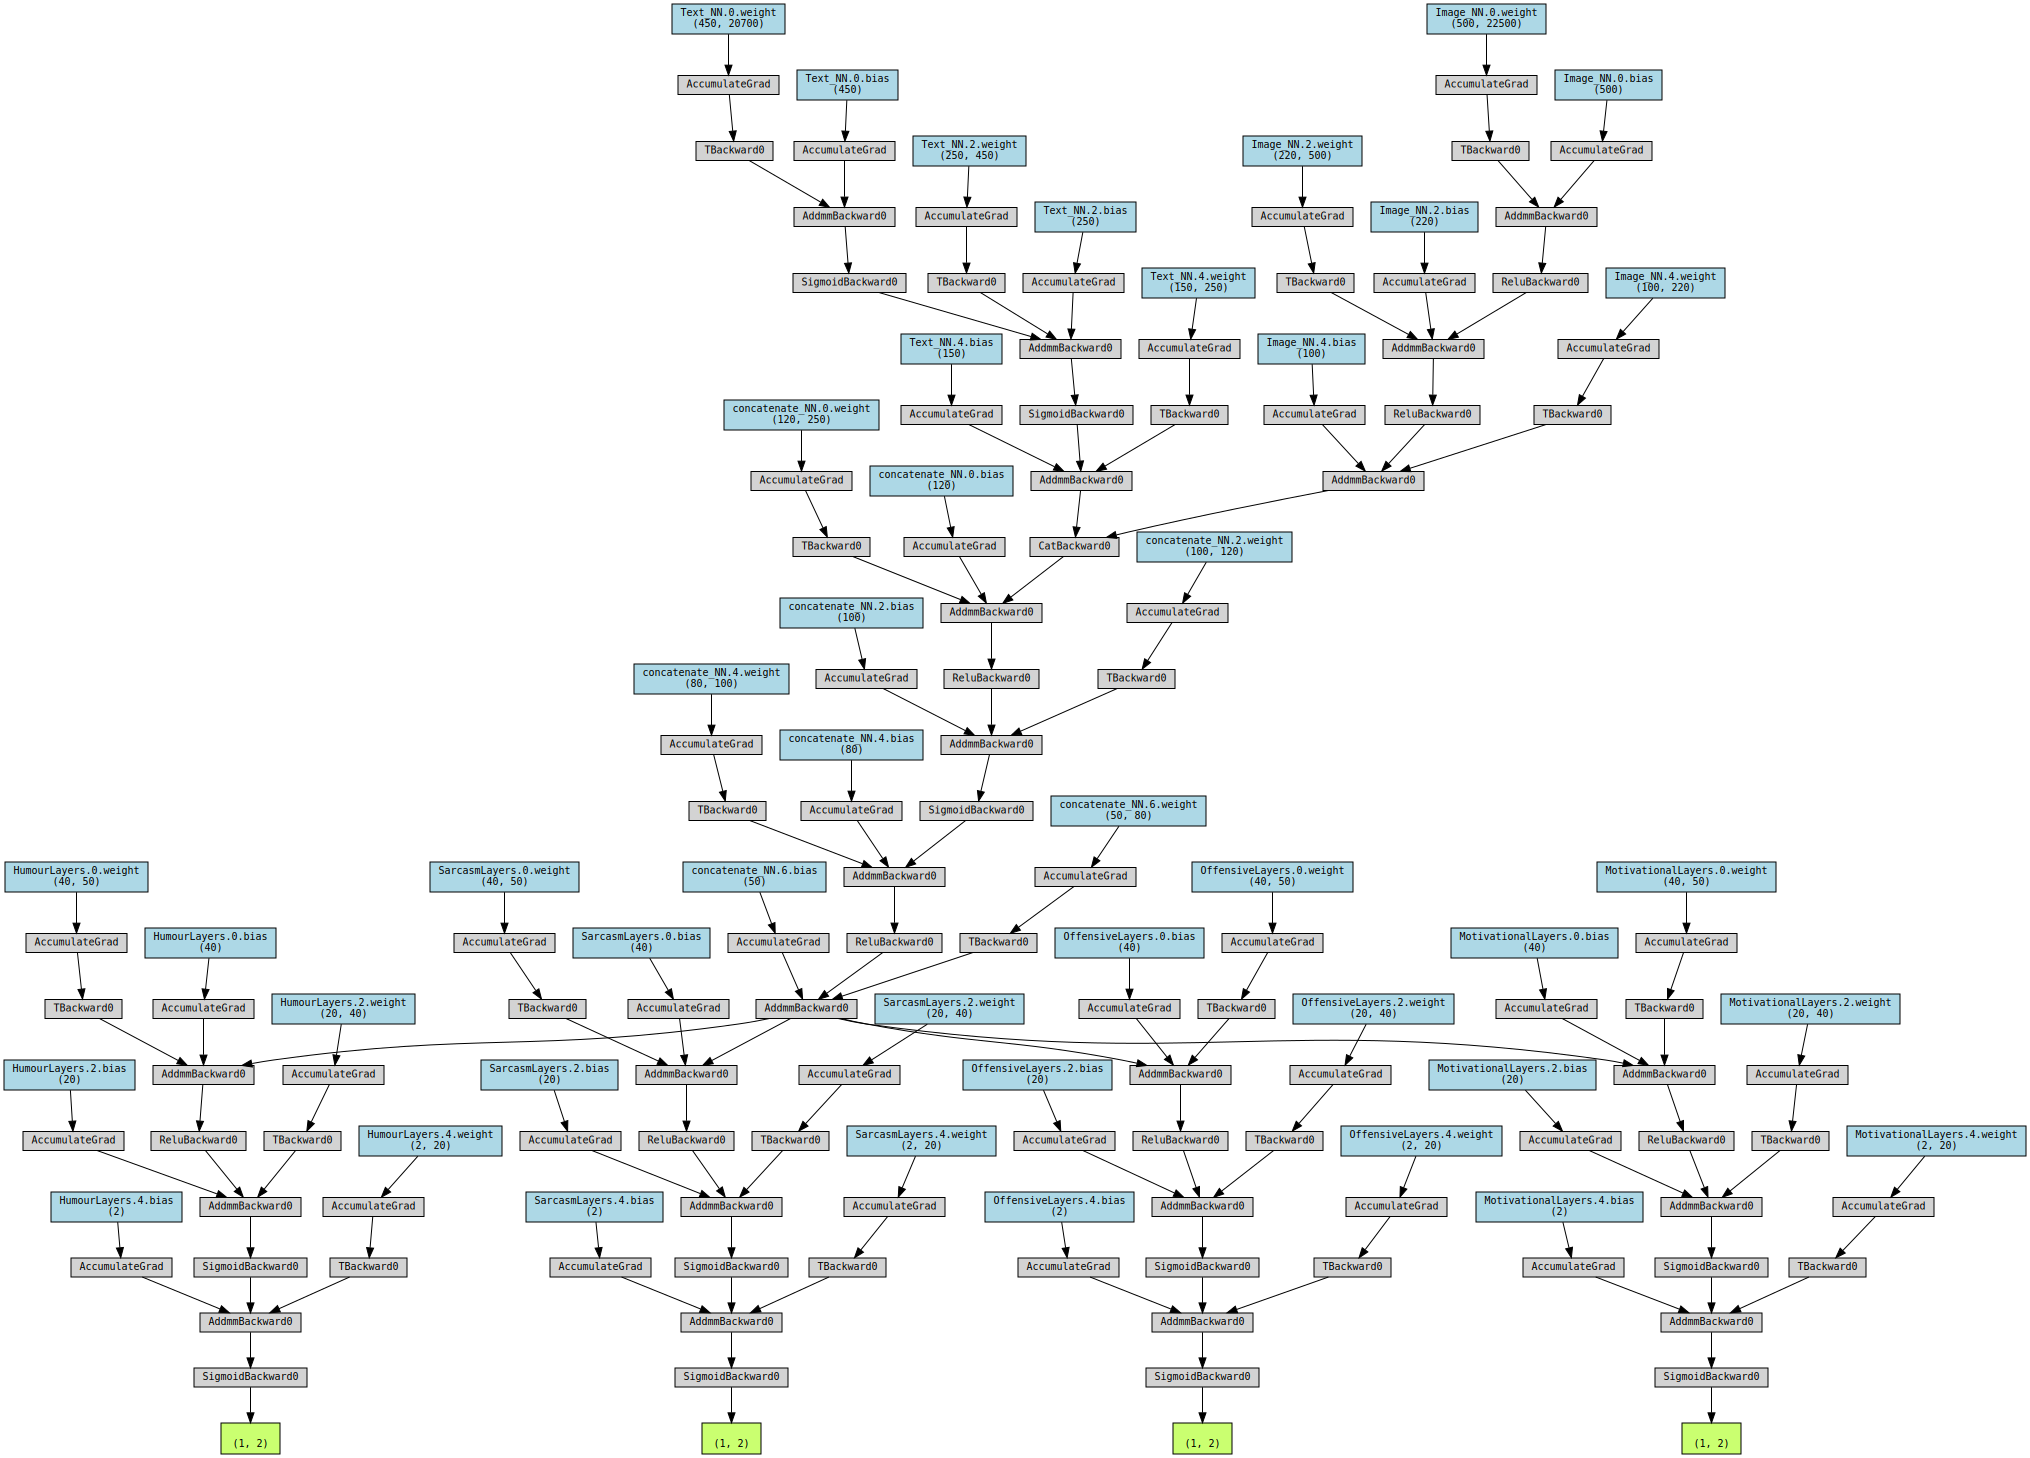


(evince:360225): Gtk-WARNING **: 10:50:30.190: Could not load a pixbuf from icon theme.
This may indicate that pixbuf loaders or the mime database could not be found.


In [49]:
from torchviz import make_dot
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

for i, feature in enumerate(train_loader):
    output = model(feature['image'], feature['text'])
    break

# Visualize the model
make_dot(output, params=dict(model.named_parameters())).render('model2_architecture.gv', view=True)
make_dot(output, params=dict(model.named_parameters()))


In [33]:
# import accuracy_score and F1 score
from sklearn.metrics import accuracy_score, f1_score

#### Model - Training

In [39]:
# Calculate the loss
def criterion (outputs, labels):
    # print(outputs, labels)
    loss = 0
    for i in range(len(outputs)):
        lab = labels.squeeze(1)
        lab = lab[:, i]
        lab = lab.long()
        loss += nn.CrossEntropyLoss()(outputs[i], lab)
    return loss

optimizer = torch.optim.SGD(model.parameters(), lr=0.000015) 
epochs = 30
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
shape = 30
loss_list = []
f1_score_list = []
y_preds = []
y_true = []

for epoch in range(epochs):
    lr = 1e-5
    for i, feature in enumerate(train_loader):

        optimizer.zero_grad()

        # Forward Pass
        output = model(feature['image'], feature['text'])

        # Loss
        loss = criterion(output, feature['labels'])

        # Backward Pass
        loss.backward()
        optimizer.step()

        # Get a list of 4 Predicted labels each as 0 or 1
        predicted_labels = []
        for i in range(len(output)):
            predicted_labels.append(torch.argmax(output[i], 1))

        # Reorganize the predicted labels to 10*4
        predicted_labels = torch.cat(predicted_labels)


        y_true = feature['labels']

        predicted_labels = predicted_labels.flatten()
        y_true = y_true.flatten()

        # Calculate the accuracy
        accuracy = accuracy_score(y_true, predicted_labels)*100
        f1_sc = f1_score(y_true, predicted_labels, average='macro')*100

        f1_score_list.append(f1_sc)

    print("Epoch: {}/{}".format(epoch+1, epochs), " | Loss: {:.4f}".format(loss.item()), " | Accuracy: {:.4f}".format(accuracy), " | F1 Score: {:.4f}".format(f1_sc))

print("F1 Score: ", max(f1_score_list))

Epoch: 1/30  | Loss: 2.7514  | Accuracy: 40.3846  | F1 Score: 40.1855
Epoch: 2/30  | Loss: 2.8154  | Accuracy: 46.1538  | F1 Score: 45.8333
Epoch: 3/30  | Loss: 2.7373  | Accuracy: 40.3846  | F1 Score: 38.5437
Epoch: 4/30  | Loss: 2.7654  | Accuracy: 36.5385  | F1 Score: 36.3265
Epoch: 5/30  | Loss: 2.8089  | Accuracy: 44.2308  | F1 Score: 44.2101
Epoch: 6/30  | Loss: 2.7432  | Accuracy: 51.9231  | F1 Score: 51.9053
Epoch: 7/30  | Loss: 2.7339  | Accuracy: 57.6923  | F1 Score: 56.0676
Epoch: 8/30  | Loss: 2.7639  | Accuracy: 46.1538  | F1 Score: 44.8485
Epoch: 9/30  | Loss: 2.8149  | Accuracy: 48.0769  | F1 Score: 48.0577
Epoch: 10/30  | Loss: 2.7759  | Accuracy: 38.4615  | F1 Score: 36.9697
Epoch: 11/30  | Loss: 2.7504  | Accuracy: 42.3077  | F1 Score: 40.9091
Epoch: 12/30  | Loss: 2.7339  | Accuracy: 40.3846  | F1 Score: 38.5437
Epoch: 13/30  | Loss: 2.7691  | Accuracy: 26.9231  | F1 Score: 25.9370
Epoch: 14/30  | Loss: 2.7853  | Accuracy: 44.2308  | F1 Score: 41.6183
Epoch: 15/30  |

#### Save the Model

In [40]:
# Save the Model to path specified 
torch.save(model.state_dict(), model_path)

In [52]:
# Load the Model from path specified
MMNN_model_part2 = MultiLabelClassification_NN(
    Net1_input, Net1_hidden1, Net1_hidden2, Net1_hidden3,
    Net2_input, Net2_hidden1, Net2_hidden2, Net2_hidden3,
    concat_hidden1, concat_hidden2, concat_hidden3, output,
    humour_hidden1, humour_hidden2, humour_hidden3,
    sarcasm_hidden1, sarcasm_hidden2, sarcasm_hidden3,
    offensive_hidden1, offensive_hidden2, offensive_hidden3,
    motivational_hidden1, motivational_hidden2, motivational_hidden3)
MMNN_model_part2.load_state_dict(torch.load(model_path))
MMNN_model_part2.eval()

MultiLabelClassification_NN(
  (Image_NN): Sequential(
    (0): Linear(in_features=22500, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=220, bias=True)
    (3): ReLU()
    (4): Linear(in_features=220, out_features=100, bias=True)
  )
  (Text_NN): Sequential(
    (0): Linear(in_features=20700, out_features=450, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=450, out_features=250, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=250, out_features=150, bias=True)
  )
  (concatenate_NN): Sequential(
    (0): Linear(in_features=250, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=80, bias=True)
    (5): ReLU()
    (6): Linear(in_features=80, out_features=50, bias=True)
  )
  (HumourLayers): Sequential(
    (0): Linear(in_features=50, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=

#### Test Model

In [ ]:
# Test Model 
test_loader = DataLoader(test_images, batch_size=30, shuffle=False)
shape = 30


for i, feature in enumerate(test_loader):
    output = model(feature['image'], feature['text'])

    # Get a list of 4 Predicted labels each as 0 or 1
    predicted_labels = []
    for i in range(len(output)):
        predicted_labels.append(torch.argmax(output[i], 1))
    # Reorganize the predicted labels to 10*4
    predicted_labels = torch.cat(predicted_labels)
    y_true = feature['labels']
    predicted_labels = predicted_labels.flatten()
    y_true = y_true.flatten()
    # Calculate the accuracy
    accuracy = accuracy_score(y_true, predicted_labels)*100
    f1_sc = f1_score(y_true, predicted_labels, average='macro')*100


TypeError: list indices must be integers or slices, not str